<a href="https://colab.research.google.com/github/ladyj-dev/Wine_All_You_Want/blob/main/Machine_Learning_wine_by_type_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV

In [10]:
# Pull in csv file from AWS S3 bucket
url = "https://winedata150k.s3.us-east-2.amazonaws.com/data_cleaning/wine_matched_final.csv"
df = pd.read_csv(url)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93557 entries, 0 to 93556
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   contry               0 non-null      float64
 1   province             93557 non-null  object 
 2   region_1             93557 non-null  object 
 3   winery               93557 non-null  object 
 4   wine_type            93557 non-null  object 
 5   wine_style           93557 non-null  object 
 6   variety              93557 non-null  object 
 7   wine_name            93557 non-null  object 
 8   points               93557 non-null  int64  
 9   price                93557 non-null  float64
 10  earned_points        93557 non-null  int64  
 11  earned_points_per_$  93557 non-null  float64
 12  description          93557 non-null  object 
dtypes: float64(3), int64(2), object(8)
memory usage: 9.3+ MB


Pre-processing to ready data for ML models.

In [12]:
# reduce the df to only wine_type & description to serve as label and text
column_names = ["variety", "description"]
df = df.reindex(columns=column_names)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93557 entries, 0 to 93556
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   variety      93557 non-null  object
 1   description  93557 non-null  object
dtypes: object(2)
memory usage: 1.4+ MB


In [13]:
# rename wine type to label and description to text for ML 
df.rename(columns={"variety": "label", "description": "text"}, inplace=True)
data = df
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93557 entries, 0 to 93556
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   93557 non-null  object
 1   text    93557 non-null  object
dtypes: object(2)
memory usage: 1.4+ MB


In [14]:
# how many wine_type are in df
data["label"].value_counts()

Chardonnay            13351
Pinot Noir            13246
Cabernet Sauvignon    11891
Sauvignon Blanc        5970
Syrah                  5492
Riesling               5029
Merlot                 4801
Zinfandel              3792
Malbec                 3026
Sangiovese             2809
Tempranillo            2439
Rosé                   2416
Shiraz                 1841
Nebbiolo               1414
Pinot Grigio           1258
Cabernet Franc         1258
Pinot Gris             1252
Viognier               1227
Barbera                 956
Petite Sirah            887
Gewürztraminer          868
Grüner Veltliner        834
Port                    743
Chenin Blanc            631
Grenache                585
Albariño                529
Prosecco                515
Moscato                 378
Torrontés               363
Dolcetto                332
Garganega               307
Gamay                   299
Montepulciano           272
Sémillon                214
Zweigelt                199
Petit Verdot        

In [15]:
data["text"].head()

0    Mac Watson honors the memory of a wine once ma...
1    This spent 20 months in 30% new French oak, an...
2    This re-named vineyard was formerly bottled as...
3    The producer sources from two blocks of the vi...
4    From 18-year-old vines, this supple well-balan...
Name: text, dtype: object

Ready to drill into the data by using train and test to divide it.

In [16]:
X = data["text"]
y = data["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Tokenize text using the bag of words technique to extract features

In [17]:
count_vect = CountVectorizer()
count_vect

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [19]:
# create bag of words for training data 
X_train_counts = count_vect.fit_transform(X_train)
X_train_counts.shape

(70167, 22291)

In [20]:
# CountVectorizer supports counts of consecutive words. Once fitted the vectorizer builds a dict of feature indices
count_vect.vocabulary_.get(u"algorithm")

In [21]:
# calculate TF & TF-IDF 
tfidf_transformer = TfidfTransformer(use_idf=False)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(70167, 22291)

Notice the output above is the dimension of the Document-Term matrix and the same shape as our X_train_counts shape.

Using Naive Bayes Classifier - most common for word counts

In [23]:
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [24]:
# select text from a row of X_test
new_wine_description = [X_test.iloc[0]]

new_wine_description

['While there are plenty of firm tannins and weight here, the wine does feel somewhat hollow. The red fruits are there, showing slowly against the tannins. It has fine final acidity, but not the power and concentration you should expect.']

Test time!

In [25]:
y_test.iloc[0]

'Pinot Noir'

It worked, it really worked! Baby steps we have a long way to go. Now to building a pipeline.

In [26]:
text_clf = Pipeline([
      ("vect", CountVectorizer()),
      ("tfidf", TfidfTransformer()),
      ("clf", MultinomialNB()),
])

In [27]:
text_clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [28]:
docs_test = data["text"]
predicted = text_clf.predict(docs_test)
np.mean(predicted == data["label"])

0.48341652682322006

Use Support Vector Machine (SGD) for next test.

In [31]:
text_clf = Pipeline ([
    ("vect", CountVectorizer()),
    ("tfidf", TfidfTransformer()),
    ("clf", SGDClassifier())
])
text_clf.fit(data["text"], data["label"])

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                               max_iter=1000,

I dont see the second step, will do further exploration on that and revisit.

In [32]:
predicted = text_clf.predict(data["text"])
np.mean(predicted == data["label"])

0.8144553587652447

In [33]:
# Scikit-learn analysis of results
print(metrics.classification_report(data["label"], predicted))

                    precision    recall  f1-score   support

          Albariño       0.91      0.60      0.72       529
           Barbera       0.93      0.84      0.88       956
     Blaufränkisch       0.91      0.71      0.80       187
    Cabernet Franc       0.83      0.52      0.64      1258
Cabernet Sauvignon       0.77      0.85      0.81     11891
        Chardonnay       0.79      0.95      0.87     13351
         Chasselas       0.09      0.20      0.13         5
      Chenin Blanc       0.92      0.58      0.71       631
          Cinsault       0.19      0.20      0.19        25
          Dolcetto       0.96      0.83      0.89       332
          Frappato       0.68      0.63      0.66        30
             Gamay       0.90      0.55      0.68       299
         Garganega       0.99      0.86      0.92       307
    Gewürztraminer       0.90      0.77      0.83       868
          Grenache       0.81      0.43      0.57       585
    Grenache Blanc       0.50      0.11

In [35]:
metrics.confusion_matrix(data["label"], predicted)

array([[ 318,    0,    0, ...,    1,    0,    0],
       [   0,  801,    0, ...,    1,   13,    0],
       [   0,    0,  132, ...,    0,    0,    1],
       ...,
       [   1,    0,    0, ...,  783,    1,    0],
       [   0,    5,    2, ...,    0, 3108,    0],
       [   0,    0,    0, ...,    0,    0,  153]])

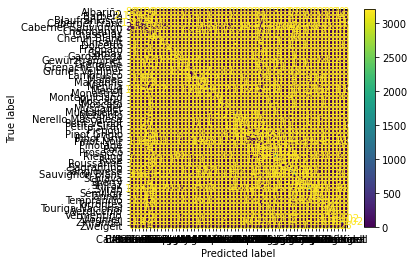

In [34]:
# confusion matrix suggestion from TA, will come back and fix the labels
plot_confusion_matrix(text_clf, X_test, y_test)

In [44]:
# (1e-2, 1e-3 is the same as .01 or .001)
parameters = {
    "vect__ngram_range": [(1,1), (1,2)],
    "tfidf__use_idf" : (True, False),
    "clf__alpha" : (1e-2, 1e-3),
}
# had issue with underscore

In [45]:
gs_clf = GridSearchCV(text_clf, parameters, cv=5, n_jobs=-1)

In [46]:
gs_clf = gs_clf.fit(data["text"], data["label"])

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [47]:
gs_clf.best_score_

0.7469036493726533

In [49]:
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

clf__alpha: 0.001
tfidf__use_idf: True
vect__ngram_range: (1, 2)
